# Clasificacion de caras

Este demo consiste en clasificar caras; es decir identificar la persona dentro de una base de datos considerando la fotografia de su cara. En este caso se asumen las caras como frontales. Este demo se basa en tutores oficiales de Tensorflow (https://www.tensorflow.org/guide/keras)

In [1]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


La base de datos Olivetti consistente en 10 fotos a 40 personas considerando una pose frontal con gestos entre ellas como cerraduta de ojos o sonrisas (https://scikit-learn.org/0.19/datasets/olivetti_faces.html). Este dataset se eligió por ser de un tamaño suficiente reducido. 


In [2]:
data=np.load("olivetti_faces.npy")
target=np.load("olivetti_faces_target.npy")

In [3]:
#Solamente corremos con 200 imagenes por motivos de tiempo en demo, es decir con 20 clases dado que el dataset esta ordenado por clases.
print(data.shape)
data=data[0:200,]
target=target[0:200,]
print(data.shape)
print("Hay {} imagenes en base de datos".format(len(data)))
print("Hay {} clases".format(len(np.unique(target))))
print("Tamaño de cada imagen es {}x{}".format(data.shape[1],data.shape[2]))
print("Los valores asociado de pixeles fueron escalados a intervalo [0,1] ejm:{}".format(data[0][0,:4]))
print("Las clases tienen codigos:",np.unique(target))

(400, 64, 64)
(200, 64, 64)
Hay 200 imagenes en base de datos
Hay 20 clases
Tamaño de cada imagen es 64x64
Los valores asociado de pixeles fueron escalados a intervalo [0,1] ejm:[0.30991736 0.3677686  0.41735536 0.44214877]
Las clases tienen codigos: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [4]:
#Division al azar para training/test
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(data, target, test_size=0.33, random_state=42)
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(134, 64, 64)
(66, 64, 64)
(134,)
(66,)


Al cargar el set de datos retorna cuatro arreglos en NumPy:

* El arreglo `train_images` y `train_labels` son los arreglos que *training set*—el modelo de datos usa para aprender.
* el modelo es probado contra los arreglos *test set*, el `test_images`, y `test_labels`.

Las imagenes son 64x64 arreglos de NumPy, con valores de pixel que varian de 0 a 255. Los *labels* son un arreglo de integros, que van del 0 al 9. Estos corresponden a la *clase*; es decir identidad de cara en imagen.

Cada imagen es mapeada a una unica etiqueta.

In [5]:
#En demo se usan estos 20 nombres solo como referencia.
class_names = ['Andres', 'Alejandro', 'Alex', 'Arturo', 'Brian','Bruno','Beto','Tania', 'Carlos','Camila',
               'Carmelo','Carlos-II', 'David','Daniel','Danilo','Duber','Enrique','Elidio','Ezequiel','Enrique-II']


## Explore el set de datos

Se observa que hay 134 imagenes en el set de entrenamiento, con cada imagen representada por pixeles de 64x64:

In [6]:
train_images.shape
# total 134 etiquetas 
#len(train_labels)

(134, 64, 64)

Cada etiqueta es un entero entre 0 y 9:

In [7]:
train_labels

array([ 4, 18,  9, 13,  5, 12, 16,  4, 11, 11,  2, 13, 10, 11,  0,  7,  4,
       18, 19,  8, 16,  3, 19,  6,  2, 14, 10,  3,  1, 19, 15,  0,  2, 12,
        0,  3, 14, 14, 10, 14,  1,  6, 11, 14, 16,  0, 19, 15,  7, 12,  6,
        4, 16,  2,  4, 10, 15, 15,  2,  2, 18, 14,  8,  3, 16,  4,  9, 15,
        4, 13,  0, 10,  5, 13, 18, 17, 18,  4,  8,  3,  0, 11,  9,  8, 17,
       18,  8,  0,  1,  5, 17, 13,  1,  7, 17, 13, 16, 18,  6,  5, 10,  5,
       19,  5,  4,  8,  2,  5, 16, 19, 12,  3, 15, 19,  0,  5, 14, 13, 15,
       10,  9, 11,  8,  7, 12, 19,  2, 18,  7, 10,  1,  9, 17, 10],
      dtype=int32)

Hay 33 imagenes en el set de pruebas. Cada imagen es representada con 64x64 pixels lo cual es correcto:

In [9]:
test_images.shape
#66 etiqueTas de pruebas
#len(test_labels)

(66, 64, 64)

## Pre-procese el set de datos

El set de datos debe ser pre-procesada antes de entrenar la red. Si usted inspecciona la primera imagen en el set de entrenamiento, usted deberia encontrar que los valores de los pixeles estan entre 0 y 255 dado que son pixeles; sin embargo dataset ya viene con datos preprocesados tal que estan en rango 0 y 1. Las imagenes se pueden graficas sin problemas:

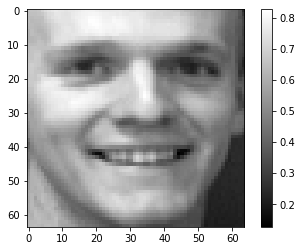

In [10]:
plt.figure()
plt.imshow(train_images[0],'gray')
plt.colorbar()
plt.grid(False)
plt.show()

Escale estos valores en un rango de 0 a 1 antes de alimentarlos al modelo de la red neuronal. Para hacero, divida los valores por 255. Es importante que el *training set* y el *testing set* se pre-procesen de la misma forma. En nuestro caso omitimos este paso dado que ya estan normalizadas las imagenes.

In [ ]:
# train_images = train_images / 255.0

# test_images = test_images / 255.0

## Construir el Modelo

En Keras, la red neuronal requiere configurar las capas del modelo y luego compilar el modelo.

### Configurar las Capas

Los bloques de construccion basicos de una red neuronal son las *capas* o *layers*. Las capas extraen representaciones de el set de datos que se les alimentan. Con suerte, estas representaciones son la clave para resolver problema.
Como estamos usando redes clasicas de conexiones densas usaremos `tf.keras.layers.Dense` las cuales tienen parametros que son aprendidos durante el entrenamiento.

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64)),
    keras.layers.Dense(128, activation='relu'),   #para pregunta 3
    keras.layers.Dense(20, activation='softmax')    #para pregunta de cantidad
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
Total params: 526,996
Trainable params: 526,996
Non-trainable params: 0
_________________________________________________________________


La primera capa de esta red, `tf.keras.layers.Flatten`, 
transforma el formato de las imagenes de un arreglo bi-dimensional (de 28 por 28 pixeles) a un arreglo unidimensional (de 64*64 pixeles = 4096 pixeles). Observe esta capa como una capa no apilada de filas de pixeles en la misma imagen y alineandolo. Esta capa no tiene parametros que aprender; solo reformatea el set de datos.

Despues de que los pixeles estan "aplanados", la secuencia consiste de dos capas`tf.keras.layers.Dense`. Estas estan densamente conectadas, o completamente conectadas. La primera capa `Dense` tiene 128 nodos (o neuronas). La segunda (y ultima) capa es una capa de 10 nodos *softmax* que devuelve un arreglo de 10 probabilidades que suman a 1. Cada nodo contiene una calificacion que indica la probabilidad que la actual imagen pertenece a una de las 10 clases.

### Compile el modelo

Antes de que el modelo este listo para entrenar , se necesitan algunas configuraciones mas. Estas son agregadas durante el paso de compilacion del modelo:

* *Loss function* —Esto mide que tan exacto es el modelo durante el entrenamiento. Quiere minimizar esta funcion para dirigir el modelo en la direccion adecuada.
* *Optimizer* — Esto es como el modelo se actualiza basado en el set de datos que ve y la funcion de perdida.
* *Metrics* — Se usan para monitorear los pasos de entrenamiento y de pruebas.
El siguiente ejemplo usa *accuracy* (exactitud) , la fraccion de la imagenes que son correctamente clasificadas.

In [12]:
model.reset_states()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Entrenar el Modelo

Entrenar el modelo de red neuronal requiere de los siguientes pasos:

1. Entregue los datos de entrenamiento al modelo. En este ejemplo , el set de datos de entrenamiento estan en los arreglos `train_images` y `train_labels`.
2. el modelo aprende a asociar imagenes y etiquetas.
3. Usted le pregunta al modelo que haga predicciones sobre un set de datos que se encuentran en el ejemplo,incluido en el arreglo `test_images`. Verifique que las predicciones sean iguales a las etiquetas de el arreglo`test_labels`.

Para comenzar a entrenar, llame el metodo `model.fit`, es llamado asi por que *fit* (ajusta) el modelo a el set de datos de entrenamiento:

In [13]:
model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=1000) #se actualiza numero a 1000

Epoch 1/1000
5/5 [==============================] - 3s 46ms/step - loss: 4.4740 - accuracy: 0.0224 - val_loss: 3.6880 - val_accuracy: 0.0758
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.4188 - accuracy: 0.0821 - val_loss: 3.1870 - val_accuracy: 0.0455
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 3.0296 - accuracy: 0.0821 - val_loss: 3.0479 - val_accuracy: 0.0606
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.8698 - accuracy: 0.1119 - val_loss: 2.9588 - val_accuracy: 0.0758
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.8400 - accuracy: 0.1418 - val_loss: 2.8590 - val_accuracy: 0.2121
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.7960 - accuracy: 0.1418 - val_loss: 2.9482 - val_accuracy: 0.0758
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.8294 - accuracy: 0.0896 - val_loss: 2.8921 - val_accuracy: 0.0455
Epoch 8/1000
5/5 [

A medida que el modelo entrena, la perdida y la exactitud son desplegadas. Este modelo alcanza una exactitud de 1.00 (o 100%) sobre el set de datos de entrenamiento. Sin embargo...

## Evaluar Exactitud

Sin embargo, al evaluar en un set independiente, tenemos:

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.9215 - accuracy: 0.8636 - 19ms/epoch - 6ms/step

Test accuracy: 0.8636363744735718


Resulta que la exactitud sobre el set de datos es un poco menor que la exactitud sobre el set de entrenamiento. Esta diferencia entre el entrenamiento y el test se debe a *overfitting* (sobre ajuste). Sobre ajuste sucede cuando un modelo de aprendizaje de maquina (ML) tiene un rendimiento peor sobre un set de datos nuevo, que nunca antes ha visto comparado con el de entrenamiento.

## Hacer predicciones

Con el modelo entrenado usted puede usarlo para hacer predicciones sobre imagenes.

In [15]:
predictions = model.predict(test_images)

Aca, el modelo ha predecido la etiqueta para cada imagen en el set de datos de *test* (prueba). Miremos la primera prediccion:

In [16]:
predictions[0]

array([4.2460240e-09, 4.2862767e-13, 2.9582838e-02, 3.7318929e-07,
       3.4588641e-07, 2.0222105e-11, 7.2192171e-13, 1.1463478e-08,
       1.3364927e-07, 9.7032070e-01, 1.2140982e-12, 3.2078442e-05,
       6.6283215e-11, 5.8625683e-06, 3.5619734e-12, 5.0100996e-11,
       5.1402774e-05, 6.1958808e-06, 4.6098350e-08, 9.5528971e-09],
      dtype=float32)

**Grafique** esto para poder ver todo el set de la prediccion de las 30 clases.

In [17]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  # plt.imshow(img, cmap=plt.cm.binary)
  plt.imshow(img,'gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(20))  #cambiar numero por cantidad
  plt.yticks([])
  thisplot = plt.bar(range(20), predictions_array, color="#777777")  #cambiar numero por cantidad
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Vamos a graficar multiples imagenes con sus predicciones. Notese que el modelo puede estar equivocado aun cuando tiene mucha confianza.

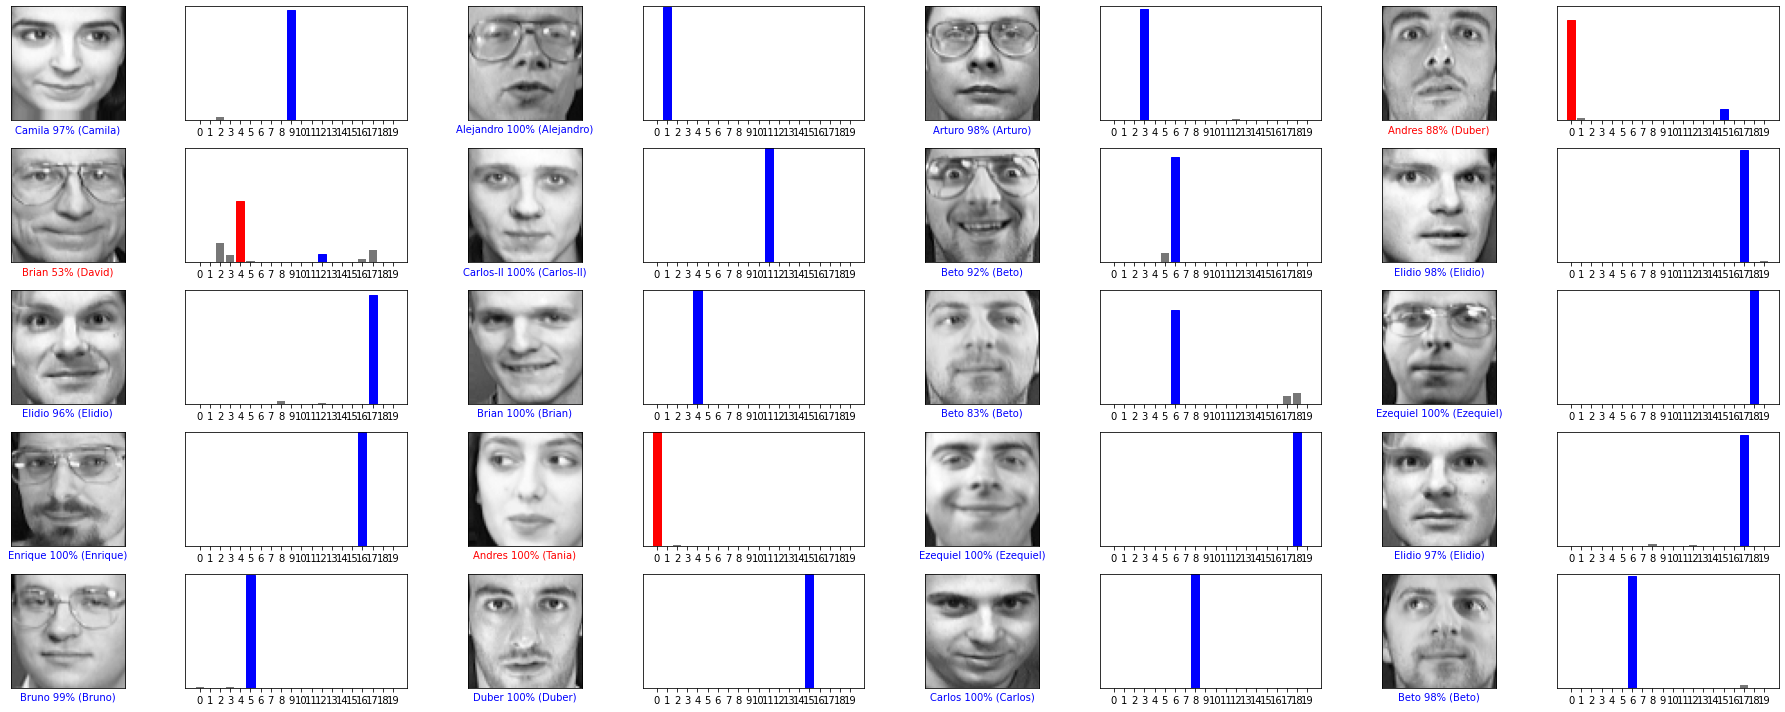

In [18]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*3.2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Aplicación en una imagen externa

Finalmente, usamos el modelo entrenado para hacer una prediccion sobre una unica imagen.

In [19]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(64, 64)


Los modelos de `tf.keras` son optimizados sobre *batch* o bloques, 
o colecciones de ejemplos por vez. Es decir debe agregar esa variable aun cuando use una unica imagen para ser testeada:

In [20]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 64, 64)


Ahora prediga la etiqueta correcta para esta imagen:

In [21]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.8615263e-04 9.9703741e-01 5.7281402e-11 5.2394613e-04 5.0699322e-07
  2.0519426e-04 3.0186508e-05 1.9473319e-09 8.6326514e-17 2.4037095e-11
  4.9187831e-04 5.2722573e-20 9.2329387e-11 2.3394472e-07 1.7205697e-10
  1.3129846e-03 4.6711315e-12 4.1579642e-06 2.0738841e-04 2.5433346e-08]]


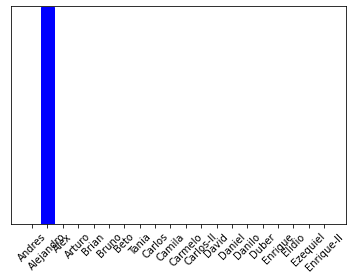

In [22]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(20), class_names, rotation=45) #actualiza el numero

`model.predict` retorna una lista de listas para cada imagen dentro del *batch* o bloque de datos. Tome la prediccion para nuestra unica imagen dentro del *batch* o bloque:

In [23]:
np.argmax(predictions_single[0])


1

**Ahora haremos la prueba final usando una red convolucional:**

In [24]:
modelconv = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,1)),
    keras.layers.MaxPooling2D((2, 2)),
    # keras.layers.Conv2D(16, (3, 3), activation='relu'),
    # keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='softmax') #actualiza el numero
])
modelconv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                615060    
                                                                 
Total params: 615,380
Trainable params: 615,380
Non-trainable params: 0
_________________________________________________________________


In [25]:
modelconv.reset_states()
modelconv.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
print(train_images.shape[0])
train_images3d = train_images.reshape(train_images.shape[0], 64, 64, 1)
test_images3d = test_images.reshape(test_images.shape[0], 64, 64, 1)
modelconv.fit(train_images3d, train_labels, validation_data=(test_images3d, test_labels), epochs=1000) #se actualiza numero a 1000

134
Epoch 1/1000
5/5 [==============================] - 9s 52ms/step - loss: 3.5910 - accuracy: 0.0522 - val_loss: 3.6851 - val_accuracy: 0.0152
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 3.3621 - accuracy: 0.0522 - val_loss: 3.3508 - val_accuracy: 0.1515
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 2.8838 - accuracy: 0.2761 - val_loss: 2.9324 - val_accuracy: 0.0152
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.7427 - accuracy: 0.0896 - val_loss: 2.8341 - val_accuracy: 0.0758
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 2.5746 - accuracy: 0.2537 - val_loss: 2.7216 - val_accuracy: 0.1515
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 2.3869 - accuracy: 0.4627 - val_loss: 2.6535 - val_accuracy: 0.2273
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 2.1946 - accuracy: 0.4851 - val_loss: 2.4736 - val_accuracy: 0.4545
Epoch 8/10